Epoch 1/5
243/243 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8678

2025-05-06 17:48:37.352903: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38535424 bytes after encountering the first element of size 38535424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-06 17:49:25.303656: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38535424 bytes after encountering the first element of size 38535424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  → Test loss: 0.2684 — Test acc: 0.9019
243/243 [==============================] - 322s 1s/step - loss: 0.2911 - accuracy: 0.8678 - val_loss: 0.3087 - val_accuracy: 0.8748 - lr: 0.0100
Epoch 2/5


2025-05-06 17:50:20.034782: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38535424 bytes after encountering the first element of size 38535424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


243/243 [==============================] - 322s 1s/step - loss: 0.2778 - accuracy: 0.8815 - val_loss: 0.2986 - val_accuracy: 0.8736 - lr: 0.0100
Epoch 3/5
243/243 [==============================] - 324s 1s/step - loss: 0.2732 - accuracy: 0.8866 - val_loss: 0.2980 - val_accuracy: 0.8772 - lr: 0.0100
Epoch 4/5
243/243 [==============================] - 324s 1s/step - loss: 0.2722 - accuracy: 0.8834 - val_loss: 0.2935 - val_accuracy: 0.8754 - lr: 0.0100
Epoch 5/5
243/243 [==============================] - ETA: 0s - loss: 0.2694 - accuracy: 0.8853

2025-05-06 18:10:59.215367: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38535424 bytes after encountering the first element of size 38535424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  → Test loss: 0.2523 — Test acc: 0.9031
243/243 [==============================] - 324s 1s/step - loss: 0.2694 - accuracy: 0.8853 - val_loss: 0.2920 - val_accuracy: 0.8784 - lr: 0.0100


/home/ale/Documentos/PID/genero_manos/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


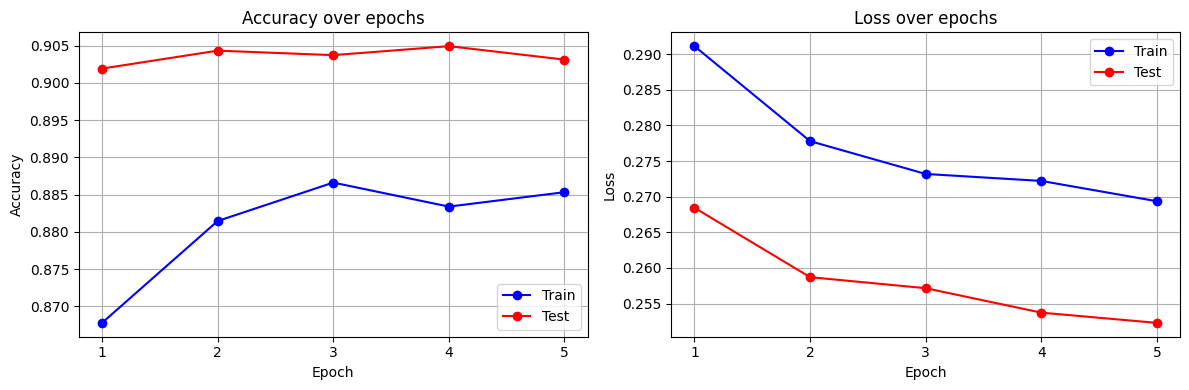

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

# ==================== Configuración ====================
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
NUM_EPOCHS = 5

CSV_PATH   = "../../dataset/HandInfo.csv"
IMAGE_ROOT = "../../dataset/image"

# ==================== Leer etiquetas ====================
df = pd.read_csv(CSV_PATH)
df["label"] = df["gender"].map({"male":0, "female":1})
NUM_CLASSES = df["label"].nunique()

# ============================== Normalización Z-score ==============================
def z_score_normalization(image: np.ndarray) -> np.ndarray:
    mean = image.mean()
    std  = image.std()
    return (image - mean) / (std + 1e-7)

# ======== Preprocesado GaussianBlur ========
def preprocess_gaussian(path_bytes: bytes) -> np.ndarray:
    path = path_bytes.decode("utf-8")
    img  = cv2.imread(path)
    if img is None:
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32)
    img = cv2.resize(img, IMG_SIZE).astype(np.float32)
    img = cv2.GaussianBlur(img, (15, 15), 0)
    return z_score_normalization(img)

# ======== Preprocesado Sobel ========
def preprocess_sobel(path_bytes: bytes) -> np.ndarray:
    path = path_bytes.decode("utf-8")
    img  = cv2.imread(path)
    if img is None:
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32)
    # resize
    img = cv2.resize(img, IMG_SIZE)
    # Sobel en X e Y
    gx  = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy  = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    # magnitud de gradiente
    img = np.sqrt(gx**2 + gy**2)
    # z-score normalization
    return z_score_normalization(img)

def make_tf_preprocess(fn):
    def _fn(path, label):
        img = tf.numpy_function(fn, [path], tf.float32)
        img.set_shape((*IMG_SIZE,3))
        return img, label
    return _fn

# ======== Construcción de datasets ========
def create_ds(split, fn):
    folder = os.path.join(IMAGE_ROOT, split)
    files  = set(os.listdir(folder))
    subdf  = df[df["imageName"].isin(files)].sort_values("imageName")
    paths  = [os.path.join(folder,n) for n in subdf["imageName"]]
    labels = subdf["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(make_tf_preprocess(fn), tf.data.AUTOTUNE)
    if split=="train":
        ds = ds.shuffle(1000)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

g_tr = create_ds("train", preprocess_gaussian)
g_va = create_ds("val",   preprocess_gaussian)
g_te = create_ds("test",  preprocess_gaussian)
s_tr = create_ds("train", preprocess_sobel)
s_va = create_ds("val",   preprocess_sobel)
s_te = create_ds("test",  preprocess_sobel)


# ======== Zip para fusión ========
train_ds = tf.data.Dataset.zip((g_tr, s_tr)) \
    .map(lambda g,s: ((g[0], s[0]), g[1]), tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.zip((g_va, s_va)) \
    .map(lambda g,s: ((g[0], s[0]), g[1]), tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.zip((g_te, s_te)) \
    .map(lambda g, s: ((g[0], s[0]), g[1]), tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

# ======== Carga de backbones preentrenados ========
gauss_model = load_model("/home/ale/Documentos/PID/genero_manos/models/Suavizado/gaussian_model.h5")
gauss_model.trainable = False
sobel_model = load_model("/home/ale/Documentos/PID/genero_manos/models/Laplacian/sobel_model.h5")
sobel_model.trainable = False

gap_g = next(l for l in gauss_model.layers if isinstance(l, GlobalAveragePooling2D))
gap_s = next(l for l in sobel_model.layers if isinstance(l, GlobalAveragePooling2D))

feat_g = Model(gauss_model.input, gap_g.output)
feat_s = Model(sobel_model.input, gap_s.output)

# ======== Montar la red de fusión ========
inp_g = layers.Input((*IMG_SIZE,3), name="in_gauss")
inp_s = layers.Input((*IMG_SIZE,3), name="in_sobel")

emb_g = feat_g(inp_g)
emb_s = feat_s(inp_s)

x = layers.Concatenate()([emb_g, emb_s])
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(NUM_CLASSES, activation="softmax")(x)

fusion = Model([inp_g, inp_s], out)

# ======== Compilar con SGD y scheduler cada 5 épocas ========
opt = SGD(learning_rate=0.01, momentum=0.9)
fusion.compile(optimizer=opt,
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

lr_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=2,
    verbose=1
)

# ======== Callbacks ========
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_ds):
        super().__init__()
        self.test_ds = test_ds
        self.test_losses = []
        self.test_accuracies = []
    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_ds, verbose=0)
        self.test_losses.append(loss)
        self.test_accuracies.append(acc)
        print(f"  → Test loss: {loss:.4f} — Test acc: {acc:.4f}")

test_cb = TestCallback(test_ds)


# ======== Entrenar conjuntamente 5 épocas ========
history = fusion.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=[lr_plateau, test_cb],
)

fusion.save("fusion_gauss_sobel.h5")

# ======== Plot ========
# — Plot Train vs Test —
epochs    = range(1, NUM_EPOCHS+1)
train_acc = history.history["accuracy"]
test_acc  = test_cb.test_accuracies
train_loss= history.history["loss"]
test_loss = test_cb.test_losses

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# Accuracy
ax1.plot(epochs, train_acc, marker='o', color='blue', label='Train')
ax1.plot(epochs, test_acc,  marker='o', color='red',  label='Test')
ax1.set_title("Accuracy over epochs")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_xticks(epochs)
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs, train_loss, marker='o', color='blue', label='Train')
ax2.plot(epochs, test_loss,  marker='o', color='red',  label='Test')
ax2.set_title("Loss over epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_xticks(epochs)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
